This notebook fits the deflector light profile of WGD 2038-4008 from a large cutout using isophote-based elliptical model.

### imports

In [1]:
import numpy as np
import os
import h5py
import joblib

import lenstronomy.Util.util as util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Sampling.parameters import Param
#from lenstronomy.Analysis.lens_analysis import LensAnalysis
from lenstronomy.Util import mask_util
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util.util import array2image


from lenstronomy.Util import param_util

cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print('Base directory path:', base_path)

Base directory path: /Users/ajshajib/Research/time_delay_cosmography/J2038/WGD2038-4008/lenstronomy_modeling


### plot settings

In [2]:
import matplotlib as mpl
import paperfig as pf

msh_cmap = pf.msh_cmap
msh_cmap2 = pf.msh_cmap2

pf.set_fontscale(2.)

### functions

In [3]:
from photutils import detect_threshold
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import deblend_sources
import numpy as np
import astropy.units as u
from photutils import source_properties, EllipticalAperture
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize


def get_mask(large_image, bkg_rms):
    """
    Create a mask covering the nearby stars/galaxies.
    """
    #threshold = detect_threshold(data, nsigma=2.)

    threshold = (3.0 * bkg_rms)  

    sigma = 6.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
    kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
    kernel.normalize()
    segm = detect_sources(large_image, threshold, npixels=5, filter_kernel=kernel)


    norm = ImageNormalize(stretch=SqrtStretch())
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
    ax1.imshow(large_image, origin='lower', cmap='Greys_r', norm=norm)
    ax1.set_title('Data')
    cmap = segm.make_cmap(random_state=12345)
    ax2.imshow(segm, origin='lower', cmap=cmap)
    ax2.set_title('Segmentation Image')


    segm_deblend = deblend_sources(large_image, segm, npixels=9,
                                   filter_kernel=kernel, nlevels=32,
                                   contrast=0.01)


    cat = source_properties(large_image, segm_deblend)
    r = 3.  # approximate isophotal extent
    apertures = []
    for obj in cat:
        position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
        a = obj.semimajor_axis_sigma.value * r
        b = obj.semiminor_axis_sigma.value * r
        theta = obj.orientation.to(u.rad).value
        apertures.append(EllipticalAperture(position, a, b, theta=theta))


    norm = ImageNormalize(stretch=SqrtStretch())
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
    ax1.imshow(large_image, origin='lower', cmap='Greys_r', norm=norm)
    ax1.set_title('Data')
    cmap = segm_deblend.make_cmap(random_state=12345)
    ax2.imshow(segm_deblend, origin='lower', cmap=cmap)
    ax2.set_title('Segmentation Image')
    for aperture in apertures:
        aperture.plot(axes=ax1, color='white', lw=1.5)
        aperture.plot(axes=ax2, color='white', lw=1.5)

    a = np.array(segm_deblend)

    s = set(a.flatten())
    area = []

    for num in s:
        if num == 0:
            continue
        counter = np.zeros_like(a)
        counter[a == num] = 1
        area.append(np.sum(counter))

    central_id = list(s)[np.argmax(area)]+1

    a[a == central_id] = 0

    plt.matshow(a, origin='lower')
    plt.title('initial segmented mask')
    plt.show()

    kernel = np.ones((11, 11),np.uint8)

    dilation = cv2.dilate(a.astype(np.uint8), kernel, iterations=1)

    plt.matshow(dilation, origin='lower')
    plt.title('dilated mask')
    plt.show()
    
    large_mask = np.zeros_like(dilation)
    large_mask[dilation == 0] = 1

    plt.matshow(np.log10(large_image*large_mask), origin='lower')
    plt.show()
    
    return large_mask

# Fit profiles

In [4]:
import warnings
warnings.filterwarnings('ignore')
import cv2
import copy
import h5py

import paperfig as pf
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import coloripy as cp

import lenstronomy.Util.class_creator as class_creator
from lenstronomy.ImSim.MultiBand.single_band_multi_model import SingleBandMultiModel

### load a model run to subtract the lensed arcs and QSO images from the deflector 

In [5]:
job_name_out = '2038_run143_0_1_2_0_0_shortened'

input_temp = os.path.join(base_path, 'temp', job_name_out +'.txt')
output_temp = os.path.join(base_path, 'temp', job_name_out +'_out.txt')

f = open(output_temp, 'rb')
[input_, output_] = joblib.load(f)
f.close()

fitting_kwargs_list, kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_

kwargs_result, multi_band_list_out, fit_output, _ = output_

band_index = 2

kwargs_data, kwargs_psf, _ = multi_band_list_out[band_index]

samples_mcmc = np.array(fit_output[-1][1])
medians = np.median(samples_mcmc, axis=0)

# walker_ratio = 8

# mcmc_repeat = 1

# samples_mcmc = np.array(fit_output[-1][1])

# print('Shape of MCMC chain:', samples_mcmc.shape)

# n_params = samples_mcmc.shape[1]

# n_walkers = 8 * n_params
# n_step = int(samples_mcmc.shape[0] / n_walkers)

# print('n_step: {}, n_walkers: {}, n_params: {}'.format(n_step, n_walkers, n_params))

# chain = np.empty((n_walkers, n_step, n_params))


# for i in np.arange(n_params):
#     samples = samples_mcmc[:, i].T
#     chain[:,:,i] = samples.reshape((n_step, n_walkers)).T


# mean_pos = np.zeros((n_params, n_step))
# median_pos = np.zeros((n_params, n_step))
# std_pos = np.zeros((n_params, n_step))
# q16_pos = np.zeros((n_params, n_step))
# q84_pos = np.zeros((n_params, n_step))

# for i in np.arange(n_params):
#     for j in np.arange(n_step):
#         mean_pos[i][j] = np.mean(chain[:, j, i])
#         median_pos[i][j] = np.median(chain[:, j, i])
#         std_pos[i][j] = np.std(chain[:, j, i])
#         q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
#         q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)
        
# burnin = -1
# last = n_step

# medians = []

# for i in range(n_params):
#     medians.append(np.median(median_pos[i][burnin:last]))

param_class = Param(kwargs_model,
                kwargs_params['lens_model'][2], 
                kwargs_params['source_model'][2],
                kwargs_params['lens_light_model'][2],
                kwargs_params['point_source_model'][2],
                kwargs_lens_init=kwargs_params['lens_model'][0], 
                **kwargs_constraints
               )

kwargs_median = param_class.args2kwargs(medians)

**Here, we subtract the lensed arcs and the quasar images from the large cutout image.**

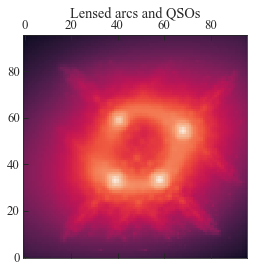

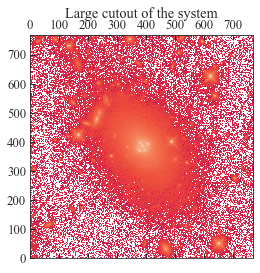

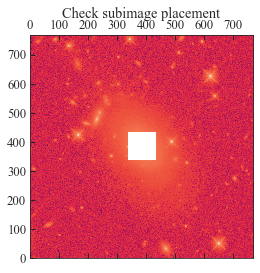

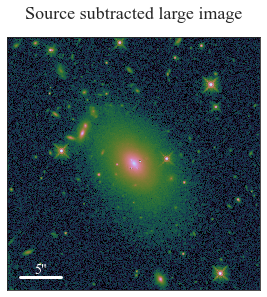

In [6]:
from rgb_functions import *

mask_list = kwargs_likelihood['image_likelihood_mask_list']
band_bool = [True] * 3
band_bool[band_index] = True

pf.set_fontscale(1.6)
fontsize = pf.mnras_figcaption_fontsize*1.6



image_model = class_creator.create_im_sim(multi_band_list_out, kwargs_data_joint['multi_band_type'], 
                                          kwargs_model,
                                          bands_compute=band_bool,
                                          likelihood_mask_list=mask_list)

model, error_map, cov_param, param = image_model.image_linear_solve(inv_bool=True, **kwargs_median)
    

band_model = SingleBandMultiModel(multi_band_list_out, kwargs_model, likelihood_mask_list=mask_list,
                                  band_index=band_index)

kwargs_lens_partial, kwargs_source_partial, kwargs_lens_light_partial, kwargs_ps_partial, _kwargs_extinction_partial = band_model.select_kwargs(**kwargs_median)
_kwargs_lens_partial, _kwargs_source_partial, _kwargs_lens_light_partial, _kwargs_ps_partial = band_model.update_linear_kwargs(param[band_index], kwargs_lens_partial, kwargs_source_partial, kwargs_lens_light_partial, kwargs_ps_partial)


data = kwargs_data['image_data']

lensed_arcs = band_model.image(_kwargs_lens_partial, _kwargs_source_partial, _kwargs_lens_light_partial,
                                          _kwargs_ps_partial, unconvolved=False, source_add=True,
                                          lens_light_add=False, point_source_add=True)

lensed_source = lensed_arcs #data - lensed_arcs

plt.matshow(np.log10(lensed_arcs), origin='lower')
plt.title('Lensed arcs and QSOs')
plt.show()

filt = 'F160W'
data_filename = '../data/data_f160w_large_cutout.hdf5'
local_data_filename = data_filename #os.path.join(base_path, 'data', data_filename)
f = h5py.File(local_data_filename, "r")

large_image_backup = f['image_data'][()]
bkg_rms = f['background_rms'][()]
wht_map = f['exposure_map'][()]
ra_at_xy_0 = f['ra_at_xy_0'][()]
dec_at_xy_0 = f['dec_at_xy_0'][()]
Matrix_inv = f['transform_pix2angle'][()]
f.close()

kwargs_data_large = {'image_data': large_image_backup, 
               'background_rms': bkg_rms,
               'noise_map': None,
               'exposure_time': wht_map,
               'ra_at_xy_0': ra_at_xy_0,
               'dec_at_xy_0': dec_at_xy_0, 
               'transform_pix2angle': Matrix_inv
               }

plt.matshow(np.log10(large_image_backup), origin='lower')
plt.title('Large cutout of the system')
plt.show()

result = cv2.matchTemplate(data.astype(np.float32), large_image_backup.astype(np.float32), cv2.TM_CCOEFF_NORMED)
match = np.unravel_index(result.argmax(),result.shape)

large_image = copy.deepcopy(large_image_backup)
large_image[match[0]:match[0]+len(lensed_source), match[1]:match[1]+len(lensed_source)] -= data

plt.matshow(np.log10(np.abs(large_image)), origin='lower')
plt.title('Check subimage placement')
plt.show()

large_image = copy.deepcopy(large_image_backup)
large_image[match[0]:match[0]+len(lensed_source), match[1]:match[1]+len(lensed_source)] -= lensed_source*mask_list[band_index]

fig = plt.figure(figsize=pf.get_fig_size(width=2*pf.mnras_textwidth/3., height_ratio=1.))
ax = fig.add_subplot(111)
ax.matshow(np.log10(np.abs(large_image)), origin='lower', cmap=pf.cmap, 
           vmax=np.log10(np.abs(large_image)).max(), vmin=-3.)
ax.set_title('Source subtracted large image', fontdict={'fontsize': pf.mnras_text_fontsize*2})

add_scale_bar(ax, length=5, fontsize=14, scale_text=None);
    
ax.set_xticks([])
ax.set_yticks([])
# plt.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/source_subtracted_large_cutout.pdf', 
#             bbox_inches='tight')
plt.show()

#large_mask = get_mask(large_image, bkg_rms)

#import numpy.ma as ma

#masked_data = ma.masked_array(large_image, 1-large_mas#

## Fit isophotes using `photutils`

In [7]:
from photutils.isophote import Ellipse, EllipseGeometry
from photutils.isophote import build_ellipse_model

**First fit the isophotes in the inner region.**

In [8]:
g = EllipseGeometry(242.+96*1.5, 240+96*1.5, 60., 0.3, 120./180.*np.pi)
g.find_center(large_image)

ellipse = Ellipse(large_image, geometry=g)
isolist = ellipse.fit_image(integrmode='median', sclip=3.0, nclip=3, fflag=0.7, maxsma=90.)

INFO: Found center at x0 = 386.0, y0 = 384.0 [photutils.isophote.geometry]


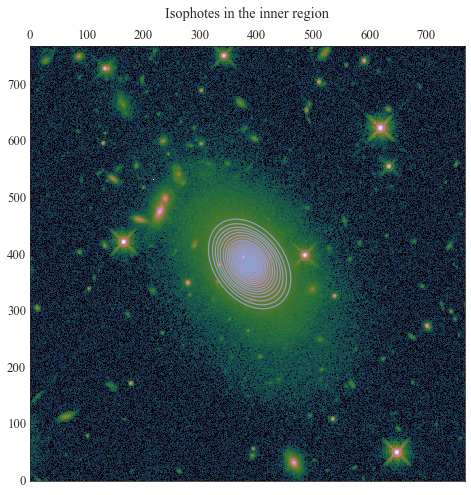

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(np.log10(np.abs(large_image)), origin='lower', cmap=pf.cmap, 
           vmax=np.log10(np.abs(large_image)).max(), vmin=-3.)
ax.set_title("Isophotes in the inner region")
#ax.set_xlim([300, 900])
#ax.set_ylim([700, 1200])

# go to the outermost successfully fitted ellipse at sma=235
isos = []
for sma in isolist.to_table()['sma']:
    iso = isolist.get_closest(sma)
    isos.append(iso)
    x, y, = iso.sampled_coordinates()
    plt.plot(x, y, color=pf.cb2_blue)



Check the intensity along the isophotes. For a good fit the same colored dots should follow horizontal lines.

Text(0, 0.5, 'Intensity')

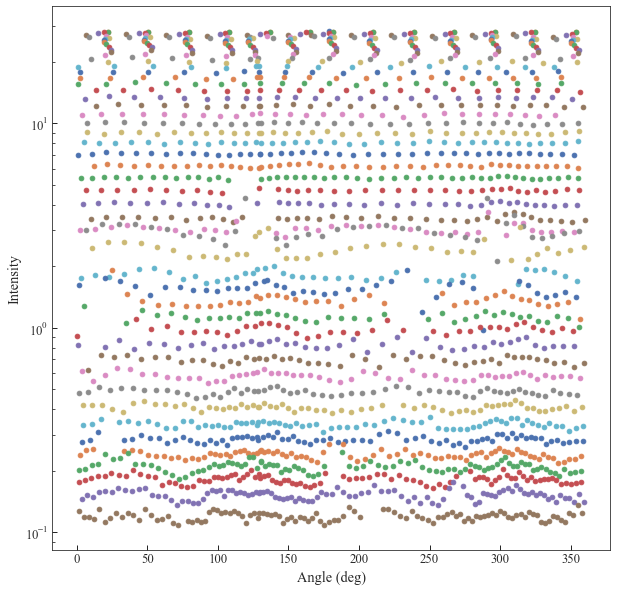

In [10]:
plt.figure(figsize=(10, 10))

for iso in isos:
    angles = ((iso.sample.values[0] + iso.sample.geometry.pa) / np.pi*180.) % 360.
    plt.scatter(angles, iso.sample.values[2])
    
plt.yscale('log')
plt.xlabel("Angle (deg)")
plt.ylabel("Intensity")

Plot the isophote-based model for the inner region.

Text(0.5, 1.05, 'Inner region model')

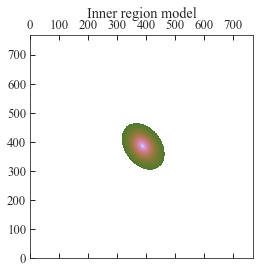

In [11]:
model_image = build_ellipse_model(large_image.shape, isolist)
#residual = data - model_image

plt.matshow(np.log10(model_image), origin='lower', cmap=pf.cmap, 
           vmax=np.log10(np.abs(large_image)).max(), vmin=-3.)
plt.title('Inner region model')

In [12]:
#plt.matshow(np.log10(model_image), origin='lower')

**Fit the outer region. The step sizes between subsequent isophotes are different in the outer region.**

In [13]:
g = EllipseGeometry(242.+96*1.5, 240+96*1.5, 60., 0.3, 120./180.*np.pi)
g.find_center(large_image)

ellipse = Ellipse(large_image, geometry=g)
isolist_outer = ellipse.fit_image(integrmode='median', step=0.1, minsma=90.,
                                       maxsma=450., fflag=0.3, sclip=3.0, nclip=3)

INFO: Found center at x0 = 386.0, y0 = 384.0 [photutils.isophote.geometry]


In [14]:
isolist_outer.to_table()

<QTable length=23>
       sma                 intens        ... niter stop_code
                                         ...                
     float64              float64        ... int64   int64  
------------------ --------------------- ... ----- ---------
 54.54545454545455    0.2872078654917226 ...    10         0
              60.0   0.24019860407491067 ...    20         0
              66.0   0.20986751341896356 ...    10         0
 72.60000000000001   0.18218182870526625 ...    10         0
 79.86000000000001    0.1526038046141521 ...    10         0
 87.84600000000002   0.11982650066090521 ...    10         0
 96.63060000000003   0.09702600122572065 ...    10         0
106.29366000000005   0.07955004775433995 ...    10         0
116.92302600000006    0.0681121601209848 ...    10         0
               ...                   ... ...   ...       ...
188.30570260326016   0.02908145163523188 ...    10         0
207.13627286358619   0.02238731079564609 ...    10         0
227.84990014994483  0.017798709715234822 ...    10         0
250.63489016493932   0.01393308814348989 ...    10         0
275.69837918143327  0.010011348210440276 ...    10         0
303.26821709957665  0.007019182922132622 ...    10         0
333.59503880953434  0.005421330868187598 ...    10         0
 366.9545426904878   0.00419826941056685 ...    10         0
 403.6499969595366  0.002961413934826851 ...     8         5
444.01499665549034 0.0023509914627169617 ...     8         5

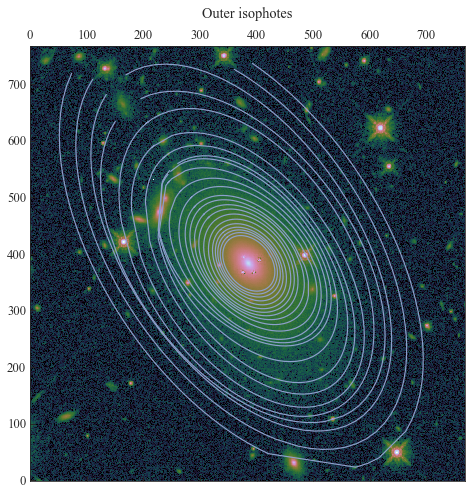

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(np.log10(np.abs(large_image)), origin='lower', cmap=pf.cmap, 
           vmax=np.log10(np.abs(large_image)).max(), vmin=-3.)
ax.set_title("Outer isophotes")

#ax.set_xlim(limits)
#ax.set_ylim(limits)

isos = []
for sma in isolist_outer.to_table()['sma']:
    iso = isolist_outer.get_closest(sma)
    isos.append(iso)
    x, y, = iso.sampled_coordinates()
    plt.plot(x, y, color=pf.cb2_blue)

Text(0, 0.5, 'Intensity')

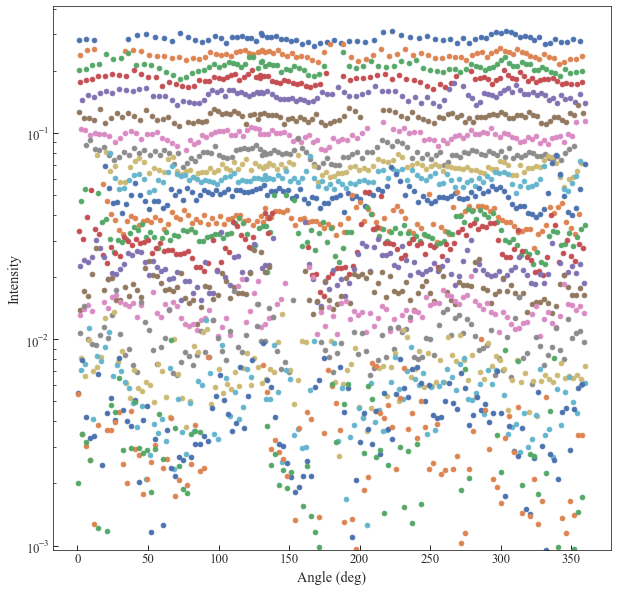

In [16]:
plt.figure(figsize=(10, 10))

for iso in isos:
    angles = ((iso.sample.values[0] + iso.sample.geometry.pa) / np.pi*180.) % 360.
    plt.scatter(angles, iso.sample.values[2])
    

plt.yscale('log')
plt.xlabel("Angle (deg)")
plt.ylabel("Intensity")

Combine the isophotes from inner region and outer region. Drop the last few isophotes in the outer region that are improperly fit.

In [17]:
isolist_full = isolist + isolist_outer[6:-2]

In [18]:
isolist_full.to_table()

<QTable length=71>
       sma                intens        ... niter stop_code
                                        ...                
     float64             float64        ... int64   int64  
------------------ -------------------- ... ----- ---------
               0.0   28.167439521693524 ...     0         0
0.5111130767700377    28.02410033614951 ...    50         2
0.5622243844470415   27.937654762187403 ...    26         0
0.6184468228917457    27.66400704375316 ...    10         0
0.6802915051809203   27.320513533298616 ...    11         0
0.7483206556990124   26.910944510763116 ...    10         0
0.8231527212689137    26.55243590540785 ...    10         0
0.9054679933958051   26.323455863916106 ...    10         0
0.9960147927353856    26.10039843355312 ...    10         0
               ...                  ... ...   ...       ...
 155.6245476060001  0.03855130126099124 ...    10         0
171.18700236660013  0.03325960026293351 ...    10         0
188.30570260326016  0.02908145163523188 ...    10         0
207.13627286358619  0.02238731079564609 ...    10         0
227.84990014994483 0.017798709715234822 ...    10         0
250.63489016493932  0.01393308814348989 ...    10         0
275.69837918143327 0.010011348210440276 ...    10         0
303.26821709957665 0.007019182922132622 ...    10         0
333.59503880953434 0.005421330868187598 ...    10         0
 366.9545426904878  0.00419826941056685 ...    10         0

In [19]:
model_image = build_ellipse_model(large_image.shape, isolist_full)
#residual = data - model_image

#plt.matshow(np.log10(model_image), origin='lower')

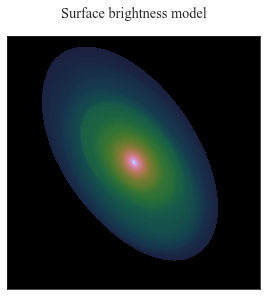

In [20]:
fig, ax = plt.subplots(figsize=pf.get_fig_size(width=2*pf.mnras_textwidth/3., height_ratio=1.))

ax.matshow(np.log10(model_image+1e-3), origin='lower', cmap=pf.cmap, 
           vmax=np.log10(np.abs(large_image)).max(), vmin=-3.)

ax.set_title('Surface brightness model')

ax.set_xticks([])
ax.set_yticks([])

# plt.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/large_coutout_model.pdf', 
#             bbox_inches='tight')
plt.show()


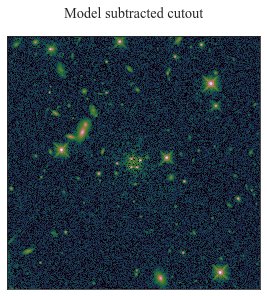

In [21]:
fig, ax = plt.subplots(figsize=pf.get_fig_size(width=2*pf.mnras_textwidth/3., height_ratio=1.))

ax.matshow(np.log10(np.abs(-model_image + large_image)), origin='lower', cmap=pf.cmap, 
           vmax=np.log10(np.abs(large_image)).max(), vmin=-3.)
ax.set_title('Model subtracted cutout')

ax.set_xticks([])
ax.set_yticks([]);


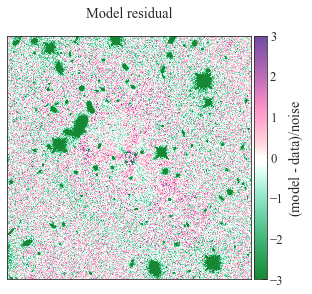

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax = plt.subplots(figsize=pf.get_fig_size(width=2*pf.mnras_textwidth/3., height_ratio=1.))

noise = np.sqrt(np.abs(kwargs_data_large['image_data'] / kwargs_data_large['exposure_time']) + kwargs_data_large['background_rms']**2)

cbar = ax.matshow((model_image - large_image)/noise, origin='lower', cmap=msh_cmap2, vmax=3, vmin=-3)

ax.set_title('Model residual')

ax.set_xticks([])
ax.set_yticks([])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(cbar, cax=cax, label=r'(model - data)$/$noise')

# plt.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/large_coutout_model_residual.pdf', 
#             bbox_inches='tight')
plt.show()


### make figure for paper

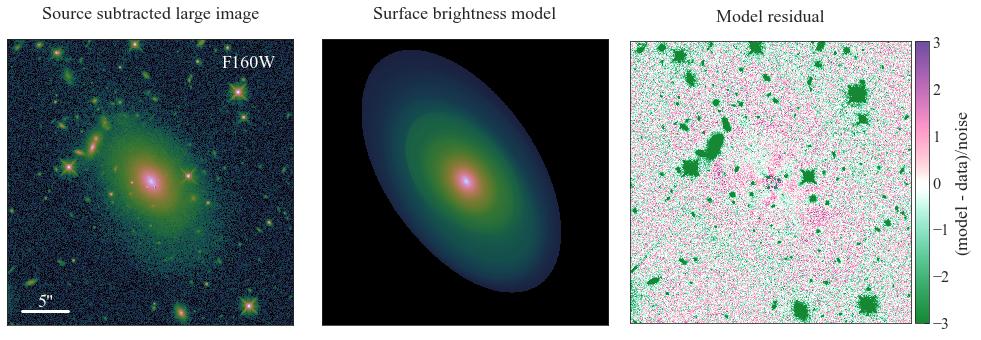

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig = plt.figure(figsize=pf.get_fig_size(width=2*pf.mnras_textwidth, height_ratio=1/3))

ax = fig.add_subplot(131)
ax.matshow(np.log10(np.abs(large_image)), origin='lower', cmap=pf.cmap, 
           vmax=np.log10(np.abs(large_image)).max(), vmin=-3.)
ax.set_title('Source subtracted large image', fontdict={'fontsize': pf.mnras_text_fontsize*2})

ax.text(0.75, 0.9, 'F160W', color='white', fontdict={'fontsize': pf.mnras_text_fontsize*2},
        transform=ax.transAxes
       )

add_scale_bar(ax, length=5, fontsize=pf.mnras_text_fontsize*2, scale_text=None);
    
ax.set_xticks([])
ax.set_yticks([])
# plt.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/source_subtracted_large_cutout.pdf', 
#             bbox_inches='tight')

ax = fig.add_subplot(132)

ax.matshow(np.log10(model_image+1e-3), origin='lower', cmap=pf.cmap, 
           vmax=np.log10(np.abs(large_image)).max(), vmin=-3.)

ax.set_title('Surface brightness model', fontdict={'fontsize': pf.mnras_text_fontsize*2})

ax.set_xticks([])
ax.set_yticks([])


ax = fig.add_subplot(133)

noise = np.sqrt(np.abs(kwargs_data_large['image_data'] / kwargs_data_large['exposure_time']) + kwargs_data_large['background_rms']**2)

cbar = ax.matshow((model_image - large_image)/noise, origin='lower', cmap=msh_cmap2, vmax=3, vmin=-3)

ax.set_title('Model residual', fontdict={'fontsize': pf.mnras_text_fontsize*2})

ax.set_xticks([])
ax.set_yticks([])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

colorbar = plt.colorbar(cbar, cax=cax)
colorbar.set_label(label=r'(model - data)$/$noise', fontsize=pf.mnras_text_fontsize*2)
colorbar.ax.tick_params(labelsize=pf.mnras_figcaption_fontsize*2)

fig.tight_layout()

# fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/large_cutout_model.pdf', 
#             bbox_inches='tight')

plt.show()


In [24]:
# total apparent magnitude

from astropy.io.fits import getheader

total_flux = np.sum(model_image)

data_total_eletrons = large_image_backup * wht_map
data_total_eletrons[data_total_eletrons < 0. ] = 0.

flux_noise = np.sqrt(data_total_eletrons/wht_map**2 + bkg_rms**2)
flux_noise[model_image <= 0] = 0.

total_flux_noise = np.sqrt(np.sum(flux_noise**2))

print(total_flux, total_flux_noise)

header = getheader('../data/reduced_data/DESJ2038-4008_F160W_drz_sci.fits')

photflam, photzpt, photplam =  header['PHOTFLAM'], header['PHOTZPT'], header['PHOTPLAM']


def get_stmag(electron_flux, photflam, photzpt):
    electron_flux = np.asarray(electron_flux)
    scalar_input = False
    if electron_flux.ndim == 0:
        electron_flux = electron_flux[None]  
        scalar_input = True

    flux = electron_flux * photflam
    mag = -2.5 * np.log10(flux) + photzpt

    if scalar_input:
        return np.squeeze(mag)

    return mag

def get_abmag(electron_flux, photflam, photzpt, photplam):
    stmag = get_stmag(electron_flux, photflam, photzpt)

    return stmag - 5. * np.log10(photplam) + 2.5 * np.log10(299792458e10) - 27.5

mag_distribution = get_abmag(np.random.normal(loc=total_flux, scale=total_flux_noise, size=1000), photflam, photzpt, photplam)

print(np.mean(mag_distribution), np.std(mag_distribution))

14139.110256891849 7.098965
15.570200495052724 0.0005374493958656177


### Find half-light radius

In [25]:
from photutils import CircularAperture
from photutils import aperture_photometry

positions = [(242+96*1.5, 240+96*1.5)]


total_flux = np.sum(model_image)

for r in range(1, 200):
    aperture = CircularAperture(positions, r=r)

    phot_table = aperture_photometry(model_image, aperture)
    if phot_table[0]['aperture_sum'] >= total_flux/2.:
        break
print("Pixels:", r, ", Radius: ", r * 0.08, "arcsecond")

Pixels: 40 , Radius:  3.2 arcsecond


In [26]:
aperture = CircularAperture(positions, r=1.36/0.08)
phot_table = aperture_photometry(model_image, aperture)

phot_table[0]['aperture_sum']/total_flux

0.29075938212587166

## Fit MGE

Here we fit a MGE to the light model to use the MGE light profiles in the kinematic computation.

In [27]:
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_twist import mge_fit_sectors_twist
from mgefit.sectors_photometry_twist import sectors_photometry_twist
from mgefit.mge_print_contours_twist import mge_print_contours_twist


### fit Gaussians to the PSF 

In [28]:
mean_psf_profile = (np.sum(kwargs_psf['kernel_point_source'], axis=0) + np.sum(kwargs_psf['kernel_point_source'], axis=1))/2.

psf_size = len(mean_psf_profile)

one_sided_psf_profile = mean_psf_profile[:int((psf_size-1)/2)+1][::-1] + mean_psf_profile[-int((psf_size-1)/2)-1:]

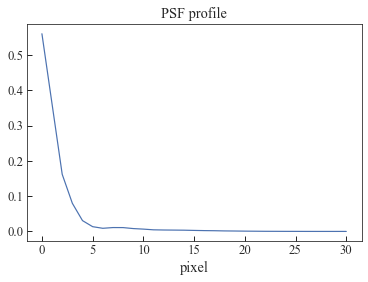

In [29]:
from scipy.interpolate import interp1d

n = 100  # number of sampled points
x = np.geomspace(0.01, 30, n)  # logarithmically spaced radii
y = interp1d(np.arange(len(one_sided_psf_profile)), one_sided_psf_profile)(x)  # The profile must be logarithmically sampled!
    
plt.plot(one_sided_psf_profile)
plt.title('PSF profile')
plt.xlabel('pixel')
plt.show()



Iteration: 1  chi2: 11.39 Nonzero: 6/9
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Iteration: 6  chi2: 3.17 Nonzero: 5/5
############################################
 Computation time: 0.03 seconds
 Total Iterations:  6
Nonzero Gaussians:  5
 Unused Gaussians:  4
 Chi2: 3.17 
 STDEV: 0.1752
 MEANABSDEV: 0.07697
############################################
 Total_Counts      Sigma
############################################
  0.000493634    0.0190788
    0.0175821     0.171928
     0.239713     0.692785
      1.42357      1.60139
      0.31035      7.23759
############################################


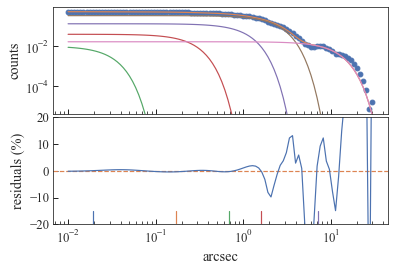

In [30]:
p = mge_fit_1d(x, y, plot=True, ngauss=9)

In [31]:
p.sol

array([[4.93633998e-04, 1.75821342e-02, 2.39712939e-01, 1.42357230e+00,
        3.10349787e-01],
       [1.90788314e-02, 1.71927709e-01, 6.92784518e-01, 1.60139184e+00,
        7.23758683e+00]])

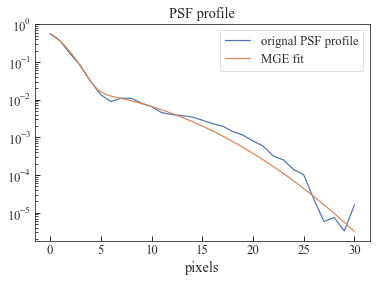

In [32]:
plt.plot(one_sided_psf_profile, label='orignal PSF profile')
plt.plot(p.x, np.sum(p.gauss*p.sol[0, :], axis=1), label='MGE fit')
plt.yscale('log')
plt.title('PSF profile')
plt.xlabel('pixels')
plt.legend()
plt.show()


### fit MGE to the galaxy model

 Pixels used: 176947
 Peak Img[j, k]: 384 385
 Mean (j, k): 383.27 385.66
 Theta (deg): 54.1
 Astro PA (deg): 35.9
 Eps: 0.397
 Major axis (pix): 312.4


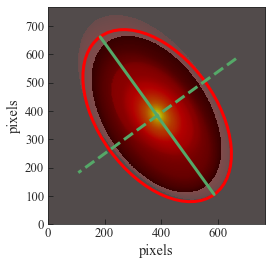

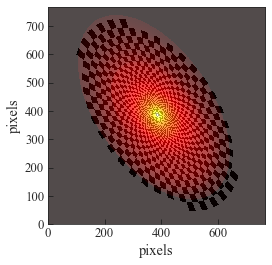

Iteration: 1  chi2: 7.248  Nonzero: 14/20
Iteration: 11  chi2: 1.318  Nonzero: 13/20
Iteration: 21  chi2: 1.034  Nonzero: 10/20
Nonzero Gaussians: 10/20
Eliminating not useful Gaussians...
ngauss: 9           chi2: 1.03
ngauss: 8           chi2: 1.03
Starting nonlinear fit...
Iteration: 1  chi2: 1.031  Nonzero: 8/8
Nonzero Gaussians: 8/8
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
 Computation time: 14.36 seconds
  Total Iterations:  25
 Nonzero Gaussians:  8
  Unused Gaussians:  12
 Sectors used in the fit:  19
 Total number of points fitted:  810
 Chi2: 1.019 
 STDEV: 0.03544 
 MEANABSDEV: 0.02052 
############################################
  Total_Counts  Sigma_Pixels      qObs
############################################
      108.691      1.72223     0.810516
      799.046      3.93909     0.678697
      1536.82      8.44827     0.663877
      2510.47      16.7011     0.757222
      2425.15      36.1159     0.714297


Iteration: 1  chi2: 7.248  Nonzero: 14/20
Iteration: 11  chi2: 1.155  Nonzero: 12/20
Iteration: 21  chi2: 1.039  Nonzero: 11/20
Iteration: 31  chi2: 1.039  Nonzero: 11/20
Iteration: 41  chi2: 1.038  Nonzero: 11/20
Iteration: 51  chi2: 1.038  Nonzero: 11/20
Iteration: 61  chi2: 1.037  Nonzero: 11/20
Iteration: 71  chi2: 1.037  Nonzero: 11/20
Iteration: 81  chi2: 1.026  Nonzero: 11/20
Nonzero Gaussians: 11/20
Eliminating not useful Gaussians...
ngauss: 10           chi2: 1.03
ngauss: 9           chi2: 1.03
ngauss: 8           chi2: 1.03
Starting nonlinear fit...
Iteration: 1  chi2: 1.029  Nonzero: 8/8
Nonzero Gaussians: 8/8
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
 Computation time: 50.37 seconds
  Total Iterations:  82
 Nonzero Gaussians:  8
  Unused Gaussians:  12
 Sectors used in the fit:  19
 Total number of points fitted:  810
 Chi2: 1.018 
 STDEV: 0.03544 
 MEANABSDEV: 0.0205 
########################################

Nonzero Gaussians: 9/9
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
 Computation time: 14.29 seconds
  Total Iterations:  21
 Nonzero Gaussians:  9
  Unused Gaussians:  11
 Sectors used in the fit:  19
 Total number of points fitted:  810
 Chi2: 1.055 
 STDEV: 0.03607 
 MEANABSDEV: 0.02093 
############################################
  Total_Counts  Sigma_Pixels      qObs
############################################
       109.89      1.73377     0.806295
      795.919      3.93822     0.678727
      1533.94      8.43243      0.66388
      2508.76      16.6853     0.756409
      2290.38      35.6215     0.716864
      1459.12      55.0656     0.743534
      915.672      68.7722     0.624745
      3816.18      140.701         0.55
      1106.21      182.437         0.95
++++++++++++++++++++++++++++++++++++++++++++
(maxloop) qbounds=0.5500 0.9500
############################################
Iteration: 1  chi2: 7.248  Nonzero:

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


############################################
Final Regularized MGE Solution:
  Total_Counts  Sigma_Pixels      qObs
############################################
      109.713      1.79424         0.75
      794.933      3.93453      0.68003
      1532.93      8.40921     0.666335
      2512.27      16.7555         0.75
      802.308         35.5     0.686823
       1541.4      35.5831         0.75
      2247.26      59.9759     0.689608
      3461.28      136.667         0.55
      1438.18      177.003         0.75
++++++++++++++++++++++++++++++++++++++++++++
Final qbounds=0.5500 0.7500
############################################


Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a 

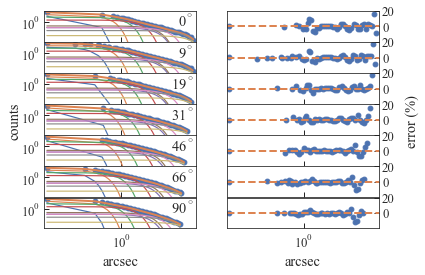

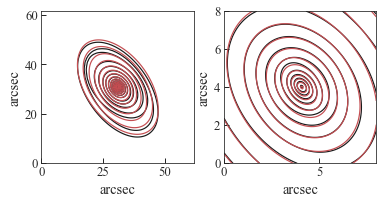

In [33]:
from mgefit.mge_fit_sectors_regularized import mge_fit_sectors_regularized

img = model_image

scale = 0.08  # arcsec/pixel
minlevel = 0.002  # counts/pixel
ngauss = 20

sigmapsf = p.sol[:, 1]      # In pixels
normpsf = p.sol[:, 0] / np.sum(p.sol[:, 0])  # total(normpsf)=1


# Here we use FIND_GALAXY directly inside the procedure. Usually you may want
# to experiment with different values of the FRACTION keyword, before adopting
# given values of Eps, Ang, Xc, Yc.
plt.clf()
f = find_galaxy(img, fraction=0.3, plot=1)
plt.show()

# Perform galaxy photometry
plt.clf()
s = sectors_photometry(img, f.eps, f.theta, f.xpeak, f.ypeak,
                       minlevel=minlevel, plot=1)
plt.show()

# Do the actual MGE fit
# *********************** IMPORTANT ***********************************
# For the final publication-quality MGE fit one should include the line
# "from mge_fit_sectors_regularized import mge_fit_sectors_regularized"
# at the top of this file, rename mge_fit_sectors() into
# mge_fit_sectors_regularized() and re-run the procedure.
# See the documentation of mge_fit_sectors_regularized for details.
# *********************************************************************
plt.clf()
m = mge_fit_sectors_regularized(s.radius, s.angle, s.counts, f.eps,
                    ngauss=ngauss, sigmapsf=sigmapsf, normpsf=normpsf,
                    scale=scale, plot=1, bulge_disk=0, linear=0)
plt.show()

# Show contour plots of the results
plt.clf()
plt.subplot(121)
mge_print_contours(img.clip(minlevel), f.theta, f.xpeak, f.ypeak, m.sol, scale=scale,
                   binning=7, sigmapsf=sigmapsf, normpsf=normpsf, magrange=9)

# Extract the central part of the image to plot at high resolution.
# The MGE is centered to fractional pixel accuracy to ease visual comparison.

n = 50
img = img[f.xpeak-n:f.xpeak+n, f.ypeak-n:f.ypeak+n]
xc, yc = n - f.xpeak + f.xmed, n - f.ypeak + f.ymed
plt.subplot(122)
mge_print_contours(img, f.theta, xc, yc, m.sol,
                   sigmapsf=sigmapsf, normpsf=normpsf, scale=scale)


In [34]:
sigmas = m.sol[1, :] * np.sqrt(1 - f.eps) * scale
amps = m.sol[0, :]

In [35]:
amps, sigmas

(array([ 109.71266358,  794.93301916, 1532.92674307, 2512.27225728,
         802.3082921 , 1541.40433211, 2247.26031178, 3461.27666923,
        1438.18065661]),
 array([ 0.11148307,  0.2444676 ,  0.52249641,  1.04108547,  2.20575275,
         2.21091594,  3.72653489,  8.49165874, 10.99787672]))

### Plot the MGE profile and compare with the isophote-based model

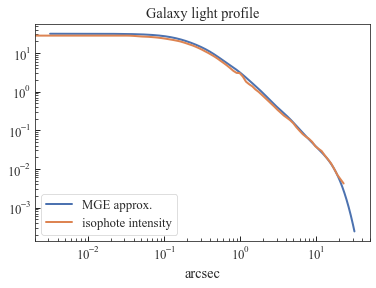

In [36]:
#plt.plot(m.radius * scale, np.sum(m.gauss*m.sol[0, :], axis=1), label='MGE fit', ls='none', marker='o')

xs = np.logspace(-2.5, 1.5, 1000)

mge_profile = 0
for a, s in zip(amps, sigmas):
    mge_profile += a / (2*np.pi) / s**2 * np.exp(-xs**2/2./s**2) * 0.08**2

amp = interp1d(xs, mge_profile)(3.2) * 8.

plt.plot(xs, mge_profile, label='MGE approx.', lw=2)
plt.plot(isolist_full.to_table()['sma'] * 0.08 * np.sqrt(1 - f.eps), 
         isolist_full.to_table()['intens'], label='isophote intensity', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.title('Galaxy light profile')
plt.xlabel('arcsec')
plt.legend()
plt.show()


In [37]:
isolist_full.intens

array([2.81674395e+01, 2.80241003e+01, 2.79376548e+01, 2.76640070e+01,
       2.73205135e+01, 2.69109445e+01, 2.65524359e+01, 2.63234559e+01,
       2.61003984e+01, 2.57406847e+01, 2.53513680e+01, 2.48909097e+01,
       2.43021945e+01, 2.36588153e+01, 2.29707524e+01, 2.22451540e+01,
       2.15400730e+01, 2.07415821e+01, 1.99374879e+01, 1.88695315e+01,
       1.77770359e+01, 1.66502970e+01, 1.56436536e+01, 1.44859412e+01,
       1.33254826e+01, 1.21847738e+01, 1.10139487e+01, 9.99849327e+00,
       8.97374038e+00, 8.03202159e+00, 7.10128401e+00, 6.18937208e+00,
       5.41697295e+00, 4.70240938e+00, 4.03017982e+00, 3.42997255e+00,
       3.04799056e+00, 3.00171312e+00, 2.44105927e+00, 1.80370421e+00,
       1.54964383e+00, 1.36756897e+00, 1.13430798e+00, 9.84463155e-01,
       8.27425112e-01, 6.94655303e-01, 5.82004736e-01, 4.86960530e-01,
       4.08075673e-01, 3.37802253e-01, 2.85625896e-01, 2.40198604e-01,
       2.09867513e-01, 1.82181829e-01, 1.52603805e-01, 1.19826501e-01,
      

In [38]:
isolist_full.to_table()

<QTable length=71>
       sma                intens        ... niter stop_code
                                        ...                
     float64             float64        ... int64   int64  
------------------ -------------------- ... ----- ---------
               0.0   28.167439521693524 ...     0         0
0.5111130767700377    28.02410033614951 ...    50         2
0.5622243844470415   27.937654762187403 ...    26         0
0.6184468228917457    27.66400704375316 ...    10         0
0.6802915051809203   27.320513533298616 ...    11         0
0.7483206556990124   26.910944510763116 ...    10         0
0.8231527212689137    26.55243590540785 ...    10         0
0.9054679933958051   26.323455863916106 ...    10         0
0.9960147927353856    26.10039843355312 ...    10         0
               ...                  ... ...   ...       ...
 155.6245476060001  0.03855130126099124 ...    10         0
171.18700236660013  0.03325960026293351 ...    10         0
188.30570260326016  0.02908145163523188 ...    10         0
207.13627286358619  0.02238731079564609 ...    10         0
227.84990014994483 0.017798709715234822 ...    10         0
250.63489016493932  0.01393308814348989 ...    10         0
275.69837918143327 0.010011348210440276 ...    10         0
303.26821709957665 0.007019182922132622 ...    10         0
333.59503880953434 0.005421330868187598 ...    10         0
 366.9545426904878  0.00419826941056685 ...    10         0

In [39]:
isolist_full.int_err

array([0.        , 0.00574245, 0.01188524, 0.03156116, 0.04193748,
       0.0536408 , 0.04996095, 0.05266414, 0.07238149, 0.06346388,
       0.06492183, 0.06970633, 0.0636235 , 0.06418433, 0.06599174,
       0.05704632, 0.05398294, 0.0515921 , 0.04574281, 0.02288327,
       0.02000093, 0.02303395, 0.02613524, 0.02107169, 0.02213201,
       0.02157028, 0.01916878, 0.01388   , 0.01319626, 0.01111101,
       0.00981156, 0.01179084, 0.00655008, 0.00820663, 0.00967259,
       0.01268297, 0.02594064, 0.06587547, 0.03746649, 0.01448655,
       0.02300083, 0.0180416 , 0.00799866, 0.00764895, 0.0050912 ,
       0.00396138, 0.00306038, 0.00203216, 0.001653  , 0.00144987,
       0.00118027, 0.00112279, 0.00127357, 0.0008839 , 0.00081083,
       0.00053862, 0.000557  , 0.00047287, 0.00044553, 0.00044298,
       0.0005861 , 0.000408  , 0.00052336, 0.00061238, 0.00035364,
       0.00026787, 0.00020575, 0.00021654, 0.00019584, 0.00019115,
       0.00017079])

In [40]:

np.array(isolist_full.to_table()['sma'] * np.sqrt(1 - isolist_full.to_table()['ellipticity']))

array([0.00000000e+00, 1.86065920e-01, 2.37295337e-01, 3.67813481e-01,
       5.03628292e-01, 6.43280489e-01, 7.48321392e-01, 8.21033465e-01,
       8.89143806e-01, 9.76371434e-01, 1.06646489e+00, 1.16832942e+00,
       1.28849135e+00, 1.42064486e+00, 1.56197937e+00, 1.70767846e+00,
       1.86021302e+00, 2.03406115e+00, 2.20326176e+00, 2.42183240e+00,
       2.65492841e+00, 2.90810204e+00, 3.16905497e+00, 3.47181721e+00,
       3.81280580e+00, 4.18338109e+00, 4.59438003e+00, 5.01392427e+00,
       5.49652467e+00, 6.01711387e+00, 6.59932646e+00, 7.27461282e+00,
       8.02031940e+00, 8.87208933e+00, 9.82524169e+00, 1.09336657e+01,
       1.19017311e+01, 1.24267750e+01, 1.40392760e+01, 1.64870054e+01,
       1.81357060e+01, 1.99492766e+01, 2.19590749e+01, 2.39588680e+01,
       2.64394268e+01, 2.90708671e+01, 3.19779538e+01, 3.50589844e+01,
       3.83696540e+01, 4.24385775e+01, 4.63596062e+01, 5.11263215e+01,
       5.56717815e+01, 6.04209085e+01, 6.62256080e+01, 7.36358778e+01,
      

## Check boxiness of light distribution

In [41]:
job_name_out = '2038_run206_1_0_1_0_0_shortened'

def custom_loglikelihood_addition(**kwargs):
    return 0.


input_temp = os.path.join(base_path, 'temp', job_name_out +'.txt')
output_temp = os.path.join(base_path, 'temp', job_name_out +'_out.txt')

f = open(output_temp, 'rb')
[input_, output_] = joblib.load(f)
f.close()

fitting_kwargs_list, kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_

kwargs_result, multi_band_list_out, fit_output, _ = output_

band_index = 2

kwargs_data, kwargs_psf, _ = multi_band_list_out[band_index]

samples_mcmc = np.array(fit_output[-1][1])
medians = np.median(samples_mcmc, axis=0)

# walker_ratio = 8

# mcmc_repeat = 1

# samples_mcmc = np.array(fit_output[-1][1])

# print('Shape of MCMC chain:', samples_mcmc.shape)

# n_params = samples_mcmc.shape[1]

# n_walkers = 8 * n_params
# n_step = int(samples_mcmc.shape[0] / n_walkers)

# print('n_step: {}, n_walkers: {}, n_params: {}'.format(n_step, n_walkers, n_params))

# chain = np.empty((n_walkers, n_step, n_params))


# for i in np.arange(n_params):
#     samples = samples_mcmc[:, i].T
#     chain[:,:,i] = samples.reshape((n_step, n_walkers)).T


# mean_pos = np.zeros((n_params, n_step))
# median_pos = np.zeros((n_params, n_step))
# std_pos = np.zeros((n_params, n_step))
# q16_pos = np.zeros((n_params, n_step))
# q84_pos = np.zeros((n_params, n_step))

# for i in np.arange(n_params):
#     for j in np.arange(n_step):
#         mean_pos[i][j] = np.mean(chain[:, j, i])
#         median_pos[i][j] = np.median(chain[:, j, i])
#         std_pos[i][j] = np.std(chain[:, j, i])
#         q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
#         q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)
        
# burnin = -1
# last = n_step

# medians = []

# for i in range(n_params):
#     medians.append(np.median(median_pos[i][burnin:last]))

param_class = Param(kwargs_model,
                kwargs_params['lens_model'][2], 
                kwargs_params['source_model'][2],
                kwargs_params['lens_light_model'][2],
                kwargs_params['point_source_model'][2],
                kwargs_lens_init=kwargs_params['lens_model'][0], 
                **kwargs_constraints
               )

kwargs_median = param_class.args2kwargs(medians)

In [42]:
from rgb_functions import *

mask_list = kwargs_likelihood['image_likelihood_mask_list']
band_bool = [True] * 3
band_bool[band_index] = True



image_model = class_creator.create_im_sim(multi_band_list_out, kwargs_data_joint['multi_band_type'], 
                                          kwargs_model,
                                          bands_compute=band_bool,
                                          likelihood_mask_list=mask_list)

model, error_map, cov_param, param = image_model.image_linear_solve(inv_bool=True, **kwargs_median)
    

band_model = SingleBandMultiModel(multi_band_list_out, kwargs_model, likelihood_mask_list=mask_list,
                                  band_index=band_index)

kwargs_lens_partial, kwargs_source_partial, kwargs_lens_light_partial, kwargs_ps_partial, _kwargs_extinction_partial = band_model.select_kwargs(**kwargs_median)
_kwargs_lens_partial, _kwargs_source_partial, _kwargs_lens_light_partial, _kwargs_ps_partial = band_model.update_linear_kwargs(param[band_index], kwargs_lens_partial, kwargs_source_partial, kwargs_lens_light_partial, kwargs_ps_partial)


data = kwargs_data['image_data']

lens_light = band_model.image(_kwargs_lens_partial, _kwargs_source_partial, _kwargs_lens_light_partial,
                                          _kwargs_ps_partial, unconvolved=False, source_add=False,
                                          lens_light_add=True, point_source_add=False)

lensed_source = band_model.image(_kwargs_lens_partial, _kwargs_source_partial, _kwargs_lens_light_partial,
                                          _kwargs_ps_partial, unconvolved=False, source_add=True,
                                          lens_light_add=False, point_source_add=True)

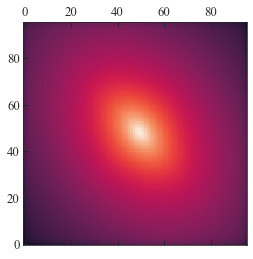

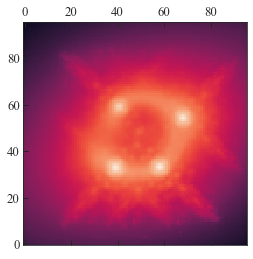

In [43]:
plt.matshow(np.log10(lens_light), origin='lower')
plt.show()

plt.matshow(np.log10(lensed_source), origin='lower')
plt.show()

In [44]:
lens_light.shape

(96, 96)

In [45]:
g = EllipseGeometry(50, 48, 5., 0.3, 30./180.*np.pi)
g.find_center(lens_light)

ellipse = Ellipse(lens_light, geometry=g)
isolist_model = ellipse.fit_image(integrmode='median', sclip=3.0, nclip=3, fflag=0.7, maxsma=50.)

INFO: Found center at x0 =  50.0, y0 =  48.0 [photutils.isophote.geometry]


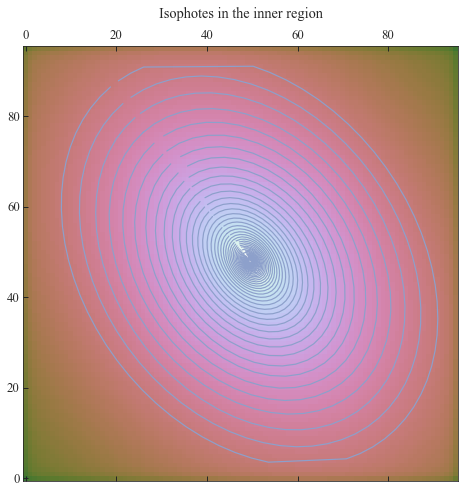

In [46]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(np.log10(np.abs(lens_light)), origin='lower', cmap=pf.cmap, 
           vmax=np.log10(np.abs(lens_light)).max(), vmin=-3.)
ax.set_title("Isophotes in the inner region")
#ax.set_xlim([300, 900])
#ax.set_ylim([700, 1200])

# go to the outermost successfully fitted ellipse at sma=235
isos_model = []
for sma in isolist_model.to_table()['sma']:
    iso = isolist_model.get_closest(sma)
    isos_model.append(iso)
    x, y, = iso.sampled_coordinates()
    plt.plot(x, y, color=pf.cb2_blue)
#     s = 20
#     plt.xlim(384.0-s, 384.0+s)
#     plt.ylim(384.0-s, 384.0+s)

In [47]:
source_subtracted_data = data - lensed_source
g = EllipseGeometry(50, 48, 5., 0.3, 30./180.*np.pi)
g.find_center(source_subtracted_data)

ellipse = Ellipse(source_subtracted_data, geometry=g)
isolist_data = ellipse.fit_image(integrmode='median', sclip=3.0, nclip=3, fflag=0.7, maxsma=50.)

INFO: Found center at x0 =  50.0, y0 =  48.0 [photutils.isophote.geometry]


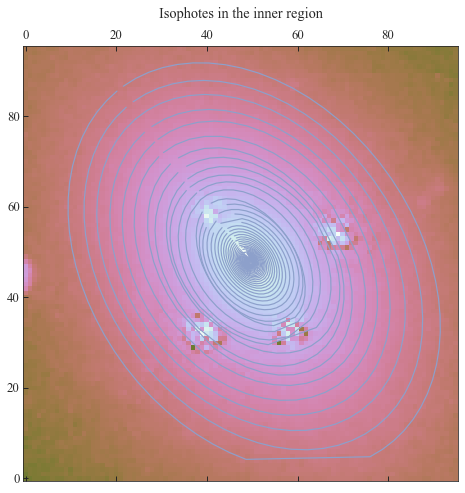

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(np.log10(np.abs(source_subtracted_data)), origin='lower', cmap=pf.cmap, 
           vmax=np.log10(np.abs(source_subtracted_data)).max(), vmin=-3.)
ax.set_title("Isophotes in the inner region")
#ax.set_xlim([300, 900])
#ax.set_ylim([700, 1200])

# go to the outermost successfully fitted ellipse at sma=235
isos_data = []
for sma in isolist_data.to_table()['sma']:
    iso = isolist_data.get_closest(sma)
    isos_data.append(iso)
    x, y, = iso.sampled_coordinates()
    plt.plot(x, y, color=pf.cb2_blue)
#     s = 20
#     plt.xlim(384.0-s, 384.0+s)
#     plt.ylim(384.0-s, 384.0+s)

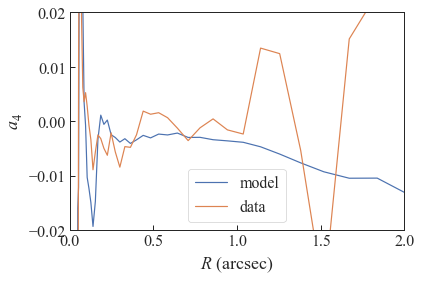

In [49]:
pf.set_fontscale(2.)

plt.plot(isolist_model.sma * 0.08, isolist_model.a4, label='model')
plt.plot(isolist_data.sma * 0.08, isolist_data.a4, label='data')

l = 0.02
plt.ylim(-l, l)
plt.xlim(0, 2)
plt.xlabel(r'$R$ (arcsec)')
plt.ylabel(r'$a_4$')
plt.legend()

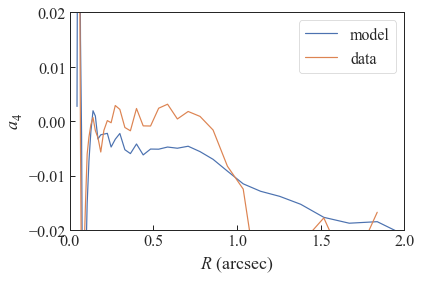

In [50]:
pf.set_fontscale(2.)

plt.plot(isolist_model.sma * 0.08, isolist_model.b4, label='model')
plt.plot(isolist_data.sma * 0.08, isolist_data.b4, label='data')

l = 0.02
plt.ylim(-l, l)
plt.xlim(0, 2)
plt.xlabel(r'$R$ (arcsec)')
plt.ylabel(r'$b_4$')
plt.legend()

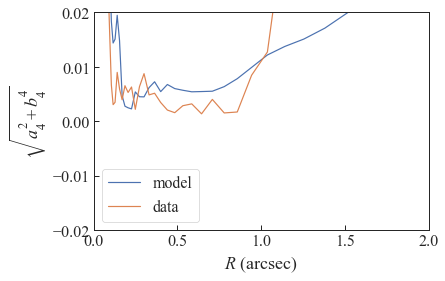

In [51]:
pf.set_fontscale(2.)

plt.plot(isolist_model.sma * 0.08, np.sqrt(isolist_model.b4**2 + isolist_model.a4**2), label='model')
plt.plot(isolist_data.sma * 0.08, np.sqrt(isolist_data.b4**2 + isolist_data.a4**2), label='data')

l = 0.02
plt.ylim(-l, l)
plt.xlim(0, 2)
plt.xlabel(r'$R$ (arcsec)')
plt.ylabel(r'$\sqrt{a_4^2 + b_4^4}$')
plt.legend()